In [90]:
from SymbolicDSGE import ModelParser, DSGESolver, Shock
from SymbolicDSGE.utils import FRED
from SymbolicDSGE.utils.math_utils import HP_two_sided, annualized_log_percent, detrend
from SymbolicDSGE.bayesian import make_prior
from SymbolicDSGE.regression import (
    SymbolicRegressor,
    TemplateConfig,
    PySRParams,
    ModelParametrizer,
)

from sympy import Matrix, Symbol, print_latex, Rational
from warnings import catch_warnings, simplefilter

from numpy import array, float64, ceil, sqrt, log, std, random, isclose
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [46]:
model, kalman = ModelParser("MODELS/POST82.yaml").get_all()

with catch_warnings():
    # Equations in a sp.Matrix are deprecated, this is only used as a pretty print function
    simplefilter(action="ignore")
    mat = Matrix(model.equations.model)
mat

Matrix([
[                                    Eq(Pi(t), beta*Pi(t + 1) + kappa*(x(t) - z(t)))],
[                           Eq(x(t), -tau_inv*(-Pi(t + 1) + r(t)) + g(t) + x(t + 1))],
[Eq(r(t), e_r + rho_r*r(t - 1*1) + (1 - rho_r)*(psi_pi*Pi(t) + psi_x*(x(t) - z(t))))],
[                                                   Eq(g(t), e_g + rho_g*g(t - 1*1))],
[                                                   Eq(z(t), e_z + rho_z*z(t - 1*1))]])

In [47]:
fred = FRED(
    key_env=None,  # None => look for the ".env" file. If you have a custom env file, provide its path here.
    key_name="FRED_KEY",  # Name of the variable in the env file that contains the FRED API key.
)
df = fred.get_frame(
    series_ids=[
        "GDPC1",  # Real GDP
        "CPIAUCSL",  # Consumer Price Index for All Urban Consumers: All Items
        "FEDFUNDS",  # Effective Federal Funds Rate
    ],
    date_range=(
        "1955-01-01",
        "1997-10-01",
    ),  # Date range for the data ("YYYY-MM-DD" format or a pd.DatetimeIndex object)
)

gdp_q = df["GDPC1"]  # already quarterly in most pulls; verify freq

cpi_q = df["CPIAUCSL"].resample("QS").mean()  # quarterly avg CPI
ffr_q = df["FEDFUNDS"].resample("QS").mean()  # quarterly avg policy rate

idx_range = pd.date_range(start="1960-01-01", end="1997-10-01", freq="QS")


df = pd.DataFrame(
    {
        "GDPC1": gdp_q.reindex(idx_range),
        "CPIAUCSL": cpi_q.reindex(idx_range),
        "FEDFUNDS": ffr_q.reindex(idx_range),
    }
)

In [74]:
x_trend = HP_two_sided(log(df["GDPC1"]), lamb=1600)[0]  # returns (trend, cycle)
x = (log(df["GDPC1"]) - x_trend) * 100  # HP detrended quarterly log output gap


inf_lvl = annualized_log_percent(df["CPIAUCSL"], periods_per_year=4)
rate_lvl = df["FEDFUNDS"]

r_ss = model.calibration.parameters["r_star"]
pi_ss = model.calibration.parameters["pi_star"]

rate = (rate_lvl - (r_ss + pi_ss)) / 4  # gap to steady state
inf = (inf_lvl - pi_ss) / 4  # gap to steady state

df_model_units = pd.DataFrame(
    {
        "r": rate,
        "Pi": inf,
        "x": x,
    }
).dropna()

observed = pd.DataFrame(
    {
        "Infl": inf_lvl[df_model_units.index],
        "Rate": rate_lvl[df_model_units.index],
    }
)
observed.index = df_model_units.index

In [75]:
def logit(p: float) -> float:
    return float(np.log(p / (1.0 - p)))


prior_spec = {
    # (0,1): x = sigmoid(z)
    "beta": make_prior(
        "normal",
        parameters={"mean": logit(0.971), "std": 0.15},
        transform="logit",
    ),
    "rho_r": make_prior(
        "normal",
        parameters={"mean": logit(0.84), "std": 0.35},
        transform="logit",
    ),
    "rho_g": make_prior(
        "normal",
        parameters={"mean": logit(0.83), "std": 0.35},
        transform="logit",
    ),
    "rho_z": make_prior(
        "normal",
        parameters={"mean": logit(0.85), "std": 0.35},
        transform="logit",
    ),
    # (0, +inf): x = exp(z)
    "psi_pi": make_prior(
        "normal",
        parameters={"mean": float(np.log(2.19)), "std": 0.25},
        transform="log",
    ),
    "psi_x": make_prior(
        "normal",
        parameters={"mean": float(np.log(0.30)), "std": 0.50},
        transform="log",
    ),
    "kappa": make_prior(
        "normal",
        parameters={"mean": float(np.log(0.58)), "std": 0.40},
        transform="affine_logit",
        transform_kwargs={"low": 0.33, "high": 1.0},
    ),
    "tau_inv": make_prior(
        "normal",
        parameters={"mean": float(np.log(1.86)), "std": 0.35},
        transform="log",
    ),
    # Correlation (-1,1)
    # Best if your affine_logit supports bounds (-1,1): x = a + (b-a)*sigmoid(z)
    "rho_gz": make_prior(
        "normal",
        parameters={"mean": logit((0.36 + 1.0) / 2.0), "std": 0.60},
        transform="affine_logit",
        transform_kwargs={
            "low": -1.0,
            "high": 1.0,
        },  # requires transform configured for (-1,1)
    ),
    # Shock std devs (0, +inf): x = exp(z)
    "sig_r": make_prior(
        "normal",
        parameters={"mean": float(np.log(0.18)), "std": 0.50},
        transform="log",
    ),
    "sig_g": make_prior(
        "normal",
        parameters={"mean": float(np.log(0.18)), "std": 0.50},
        transform="log",
    ),
    "sig_z": make_prior(
        "normal",
        parameters={"mean": float(np.log(0.64)), "std": 0.50},
        transform="log",
    ),
    "meas_infl": make_prior(
        "normal",
        parameters={"mean": 1.0, "std": 0.5},
        transform="log",
    ),
    "meas_rate": make_prior(
        "normal",
        parameters={"mean": 1.0, "std": 0.5},
        transform="log",
    ),
    "meas_rho_ir": make_prior(
        "normal",
        parameters={"mean": 0.0, "std": 0.5},
        transform="affine_logit",
        transform_kwargs={"low": -1.0, "high": 1.0},
    ),
}

solver = DSGESolver(model, kalman)
comp = solver.compile(
    n_exog=3,
    n_state=3,
)
estim = lambda r: solver.estimate_and_solve(
    compiled=comp,
    y=observed.loc[observed.index >= "1982-01-01", :],
    priors=prior_spec,
    method="mcmc",
    steady_state=[0.0, 0.0, 0.0, 0.0, 0.0],
    estimated_params=list(prior_spec.keys()),
    n_draws=1000,
    burn_in=500,
    thin=1,
    update_R_in_iterations=r,
)
res, sol = estim(False)

MCMC sampling concluded in 32.28 seconds with 46.46927818435316 iterations per second.
[Estimator:mcmc] warning signals encountered during search: 0


In [76]:
param_names = res.param_names

best_idx = np.argmax(res.logpost_trace)

post_mean = np.mean(res.samples, axis=0)
loglik = np.mean(res.logpost_trace)
accept_rate = res.accept_rate
n_draws = res.n_draws
burn_in = res.burn_in
thin = res.thin

param_to_val = dict(zip(param_names, post_mean))


pd.Series(
    {
        **param_to_val,
        "loglik": loglik,
        "accept_rate": accept_rate,
        "n_draws": n_draws,
        "burn_in": burn_in,
        "thin": thin,
    }
)

beta              0.973705
rho_r             0.792911
rho_g             0.513813
rho_z             0.871142
psi_pi            1.387276
psi_x             0.126220
kappa             0.465436
tau_inv           0.050912
rho_gz            0.777813
sig_r             0.150977
sig_g             0.294470
sig_z             0.190326
meas_infl         1.278487
meas_rate         0.642888
meas_rho_ir      -0.703442
loglik         -401.814512
accept_rate       0.320000
n_draws        1000.000000
burn_in         500.000000
thin              1.000000
dtype: float64

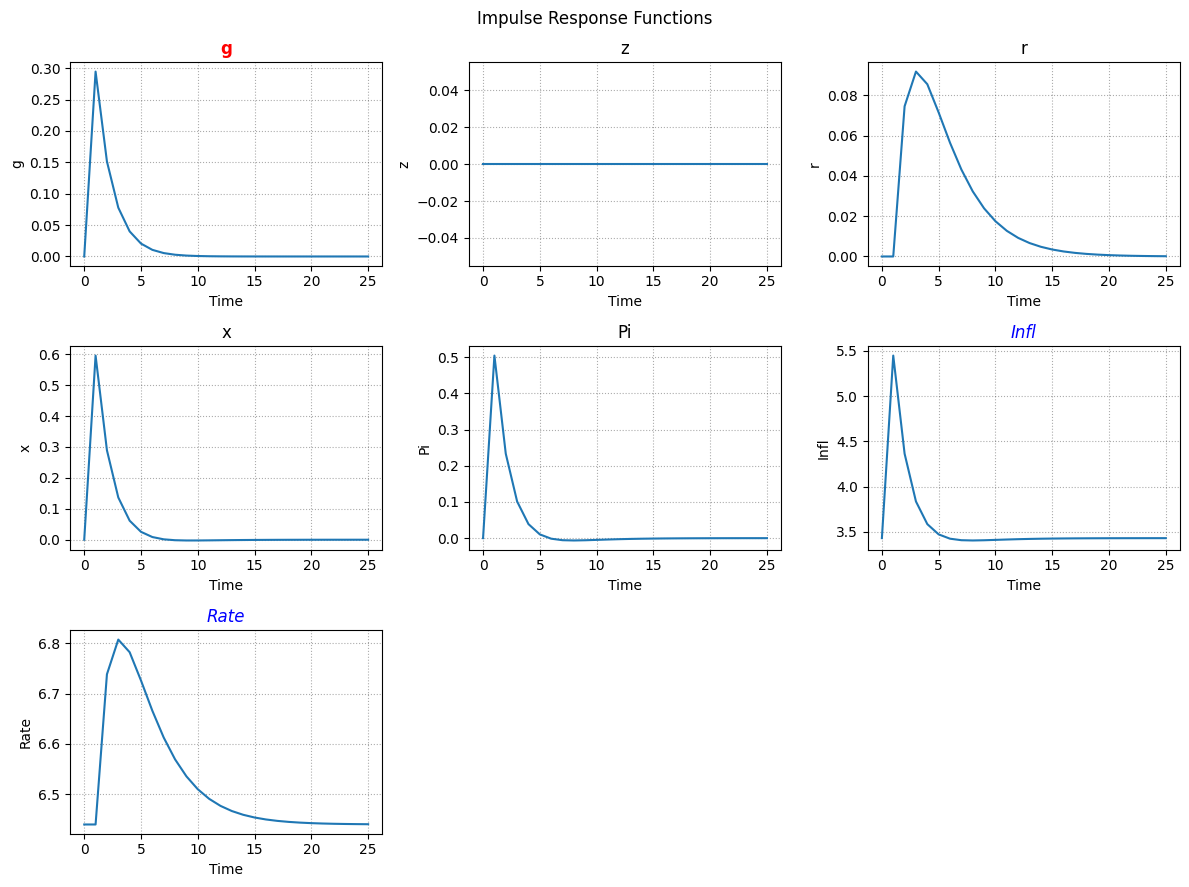

In [77]:
sol.transition_plot(shocks=["g"], T=25, scale=1, observables=True)

In [78]:
res1, sol1 = estim(True)

MCMC sampling concluded in 32.19 seconds with 46.59487003961898 iterations per second.
[Estimator:mcmc] warning signals encountered during search: 0


In [79]:
param_names1 = res1.param_names

post_mean1 = np.mean(res1.samples, axis=0)

loglik1 = np.mean(res1.logpost_trace)
accept_rate1 = res1.accept_rate
pd.Series(
    {
        **dict(zip(param_names1, post_mean1)),
        "loglik": loglik1,
        "accept_rate": accept_rate1,
        "n_draws": res1.n_draws,
        "burn_in": res1.burn_in,
        "thin": res1.thin,
    }
)

beta              0.995332
rho_r             0.797049
rho_g             0.459931
rho_z             0.795560
psi_pi            1.271786
psi_x             0.113208
kappa             0.390566
tau_inv           0.021039
rho_gz            0.954711
sig_r             0.154818
sig_g             0.502543
sig_z             0.272584
meas_infl         0.614748
meas_rate         0.147206
meas_rho_ir      -0.180938
loglik         -401.940045
accept_rate       0.265333
n_draws        1000.000000
burn_in         500.000000
thin              1.000000
dtype: float64

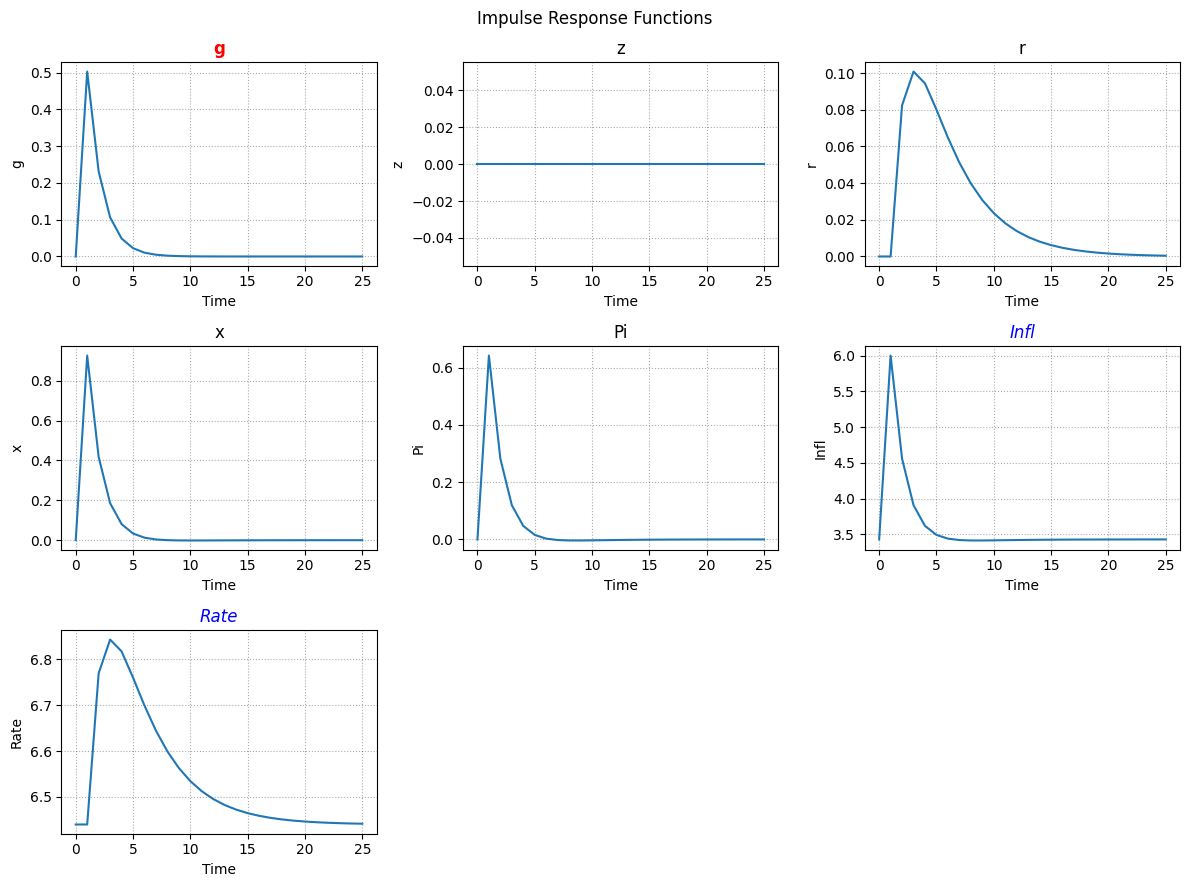

In [80]:
sol1.transition_plot(shocks=["g"], T=25, scale=1, observables=True)

In [81]:
kf_0 = sol.kalman(
    observed.loc[observed.index >= "1982-01-01", :],
    "linear",
)
kf_1 = sol1.kalman(
    observed.loc[observed.index >= "1982-01-01", :],
    "linear",
)

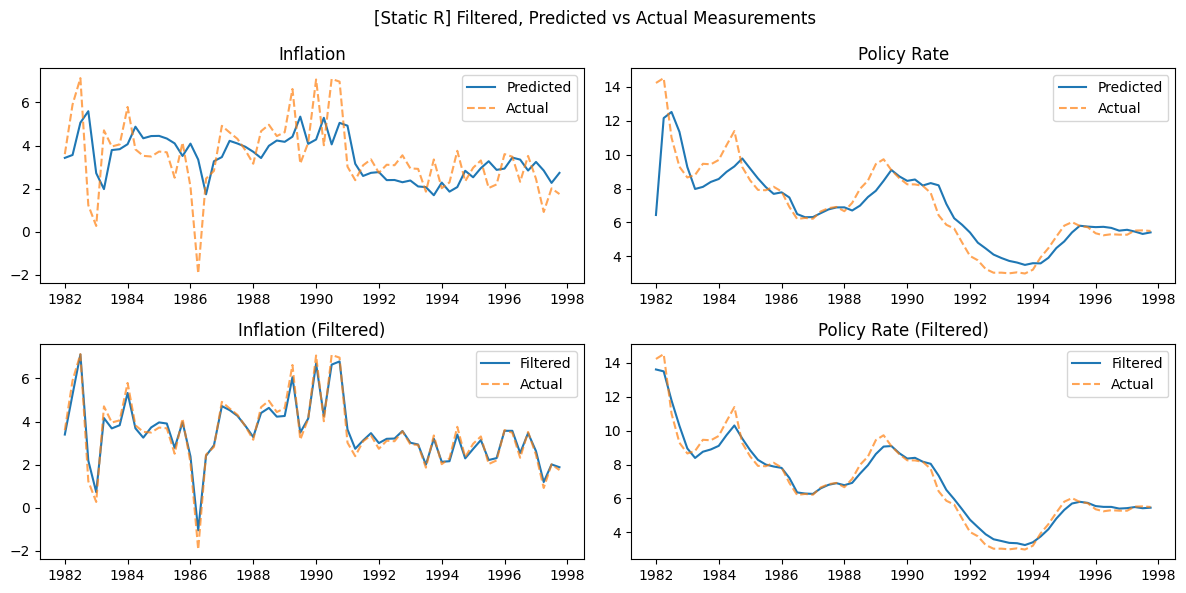

In [82]:
obs = observed.loc[observed.index >= "1982-01-01", :]
idx = obs.index

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

plt.suptitle("[Static R] Filtered, Predicted vs Actual Measurements")

ax[0].plot(idx, kf_0.y_pred[:, 0], label="Predicted")
ax[0].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[0].set_title("Inflation")
ax[0].legend()

ax[1].plot(idx, kf_0.y_pred[:, 1], label="Predicted")
ax[1].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[1].set_title("Policy Rate")
ax[1].legend()

ax[2].plot(idx, kf_0.y_filt[:, 0], label="Filtered")
ax[2].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[2].set_title("Inflation (Filtered)")
ax[2].legend()

ax[3].plot(idx, kf_0.y_filt[:, 1], label="Filtered")
ax[3].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[3].set_title("Policy Rate (Filtered)")
ax[3].legend()

plt.tight_layout()

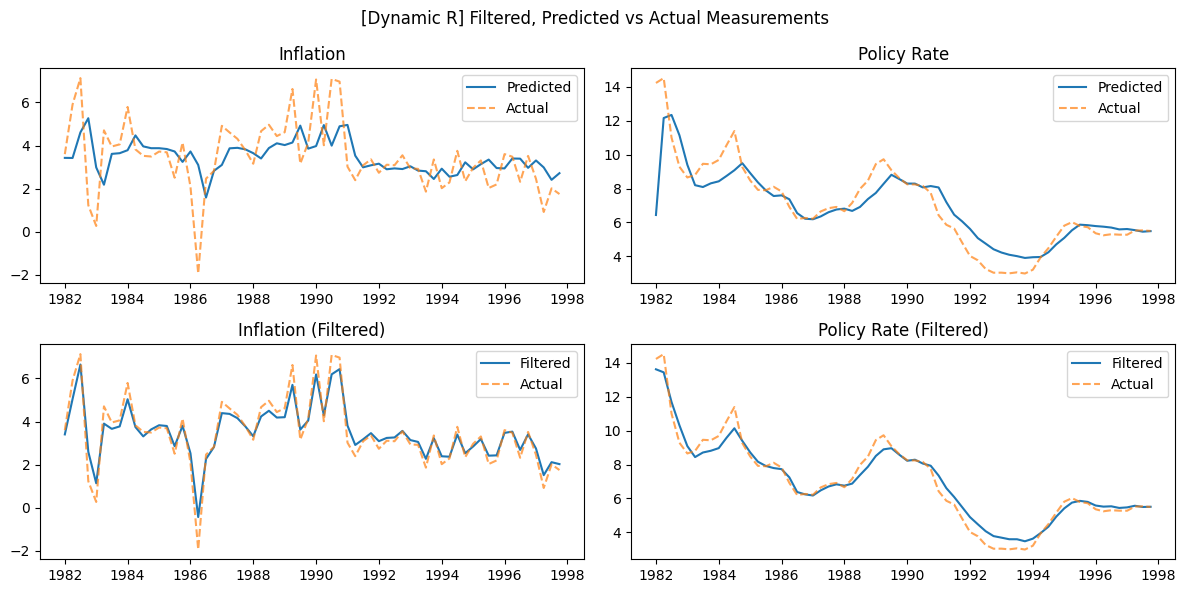

In [83]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

plt.suptitle("[Dynamic R] Filtered, Predicted vs Actual Measurements")

ax[0].plot(idx, kf_1.y_pred[:, 0], label="Predicted")
ax[0].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[0].set_title("Inflation")
ax[0].legend()

ax[1].plot(idx, kf_1.y_pred[:, 1], label="Predicted")
ax[1].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[1].set_title("Policy Rate")
ax[1].legend()

ax[2].plot(idx, kf_1.y_filt[:, 0], label="Filtered")
ax[2].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[2].set_title("Inflation (Filtered)")
ax[2].legend()

ax[3].plot(idx, kf_1.y_filt[:, 1], label="Filtered")
ax[3].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[3].set_title("Policy Rate (Filtered)")
ax[3].legend()

plt.tight_layout()

In [86]:
gz = Shock(T=len(idx) - 1, dist="norm", multivar=True, seed=0).shock_generator()
r = Shock(T=len(idx) - 1, dist="norm", seed=1).shock_generator()
sim0 = sol.sim(
    T=len(idx) - 1,
    shocks={"g,z": gz, "r": r},
    observables=True,
)

sim1 = sol1.sim(
    T=len(idx) - 1,
    shocks={"g,z": gz, "r": r},
    observables=True,
)

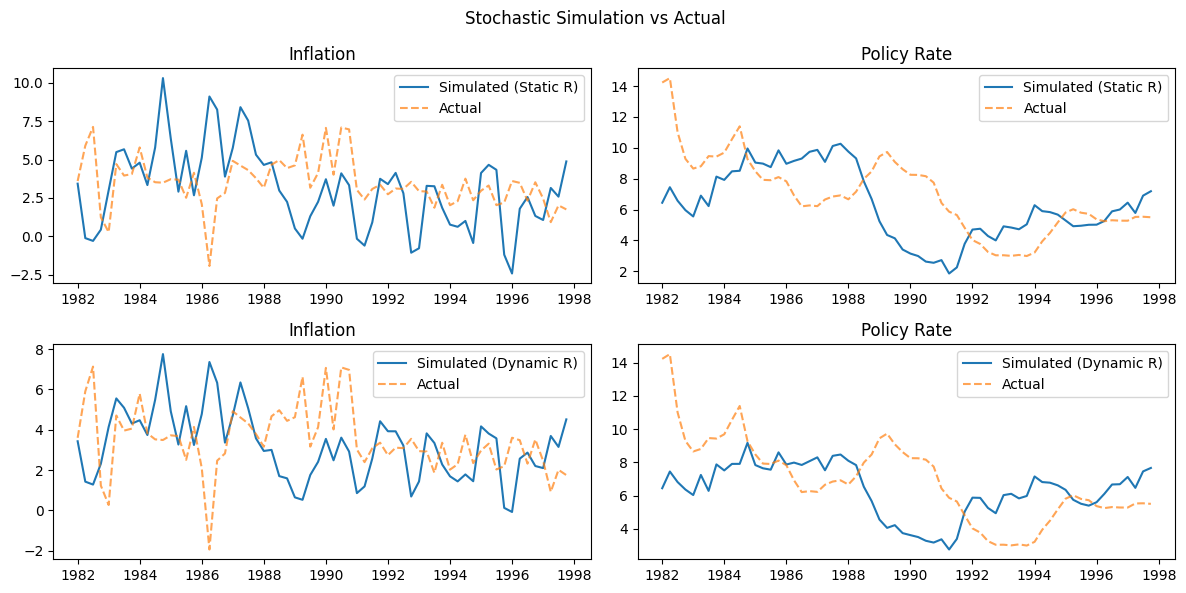

In [87]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

plt.suptitle("Stochastic Simulation vs Actual")

ax[0].plot(idx, sim0["Infl"], label="Simulated (Static R)")
ax[0].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[0].set_title("Inflation")
ax[0].legend()

ax[1].plot(idx, sim0["Rate"], label="Simulated (Static R)")
ax[1].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[1].set_title("Policy Rate")
ax[1].legend()

ax[2].plot(idx, sim1["Infl"], label="Simulated (Dynamic R)")
ax[2].plot(idx, obs.iloc[:, 0], label="Actual", linestyle="--", alpha=0.7)
ax[2].set_title("Inflation")
ax[2].legend()

ax[3].plot(idx, sim1["Rate"], label="Simulated (Dynamic R)")
ax[3].plot(idx, obs.iloc[:, 1], label="Actual", linestyle="--", alpha=0.7)
ax[3].set_title("Policy Rate")
ax[3].legend()

plt.tight_layout()

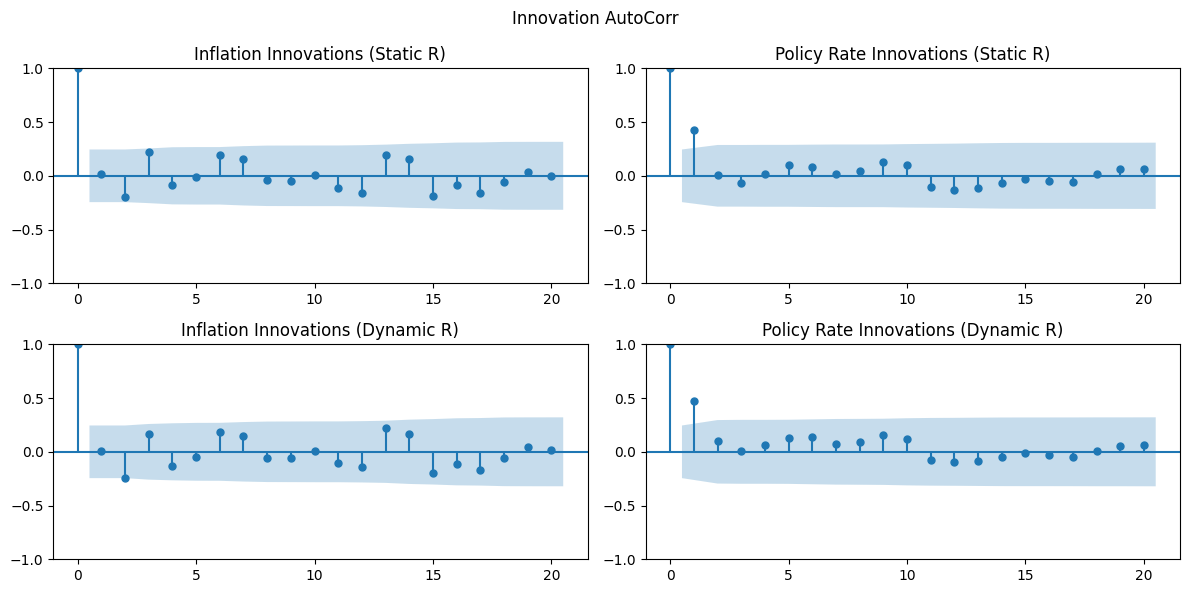

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

plt.suptitle("Innovation AutoCorr")
plot_acf(kf_0.innov[:, 0], ax=ax[0], lags=20, title="Inflation Innovations (Static R)")
plot_acf(
    kf_0.innov[:, 1], ax=ax[1], lags=20, title="Policy Rate Innovations (Static R)"
)
plot_acf(kf_1.innov[:, 0], ax=ax[2], lags=20, title="Inflation Innovations (Dynamic R)")
plot_acf(
    kf_1.innov[:, 1], ax=ax[3], lags=20, title="Policy Rate Innovations (Dynamic R)"
)
plt.tight_layout()

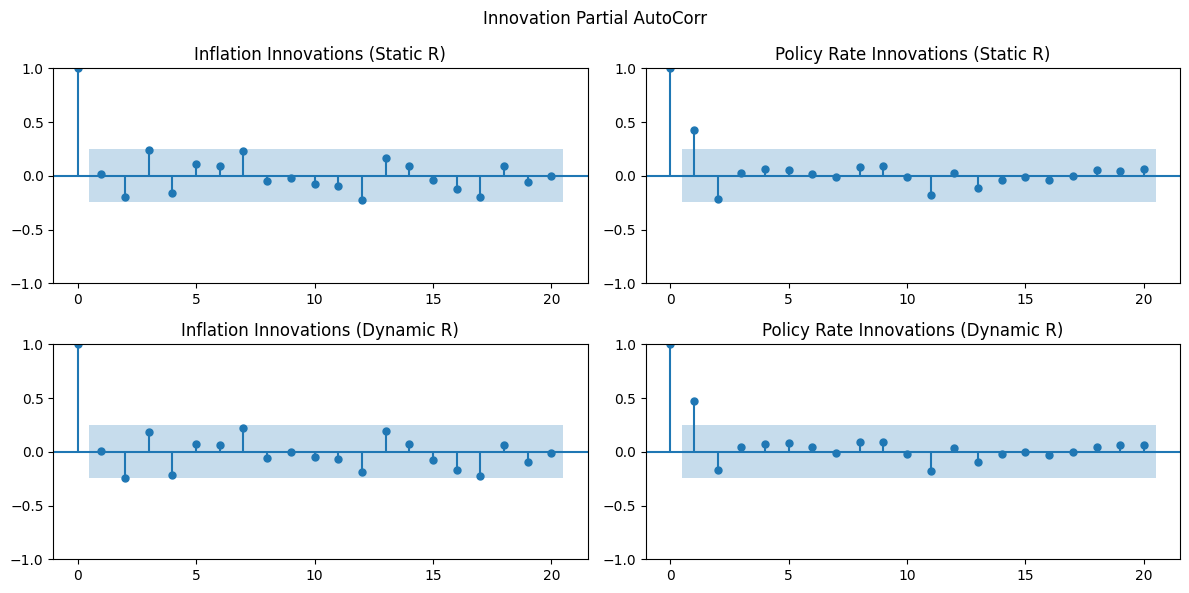

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax = ax.flatten()

plt.suptitle("Innovation Partial AutoCorr")
plot_pacf(kf_0.innov[:, 0], ax=ax[0], lags=20, title="Inflation Innovations (Static R)")
plot_pacf(
    kf_0.innov[:, 1], ax=ax[1], lags=20, title="Policy Rate Innovations (Static R)"
)
plot_pacf(
    kf_1.innov[:, 0], ax=ax[2], lags=20, title="Inflation Innovations (Dynamic R)"
)
plot_pacf(
    kf_1.innov[:, 1], ax=ax[3], lags=20, title="Policy Rate Innovations (Dynamic R)"
)
plt.tight_layout()